In [6]:
import pandas as pd
import seaborn as sns
import zipfile

## Loading the data

Load from a zipped folder and check the info.

In [9]:
zip_path = "../data/202205-capitalbikeshare-tripdata.zip"
zf = zipfile.ZipFile(zip_path) 
df = pd.read_csv(zf.open('202205-capitalbikeshare-tripdata.csv'),
                 parse_dates=["started_at", "ended_at"])
display(df.info())
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332821 entries, 0 to 332820
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             332821 non-null  object        
 1   rideable_type       332821 non-null  object        
 2   started_at          332821 non-null  datetime64[ns]
 3   ended_at            332821 non-null  datetime64[ns]
 4   start_station_name  319064 non-null  object        
 5   start_station_id    319064 non-null  float64       
 6   end_station_name    317296 non-null  object        
 7   end_station_id      317296 non-null  float64       
 8   start_lat           332821 non-null  float64       
 9   start_lng           332821 non-null  float64       
 10  end_lat             332267 non-null  float64       
 11  end_lng             332267 non-null  float64       
 12  member_casual       332821 non-null  object        
dtypes: datetime64[ns](2), float64

None

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
167441,0B85000025F56858,electric_bike,2022-05-18 11:27:50,2022-05-18 11:34:32,Anacostia Metro,31801.0,Minnesota Ave & R St SE,31826.0,38.862664,-76.994763,38.869337,-76.978519,member
79430,53E25A1D83809DCC,classic_bike,2022-05-27 16:41:21,2022-05-27 17:43:04,Gravelly Point,31064.0,Lincoln Memorial,31258.0,38.865029,-77.039511,38.888255,-77.049436,member
83177,8526FDAFB7262B7F,classic_bike,2022-05-29 17:25:34,2022-05-29 17:38:16,New York Ave & Hecht Ave NE,31518.0,D St & Maryland Ave NE,31612.0,38.915604,-76.983683,38.894841,-76.995916,member
110525,3A223C1FBADBC29C,classic_bike,2022-05-25 17:11:29,2022-05-25 18:09:17,Jefferson Dr & 14th St SW,31247.0,Connecticut Ave & R St NW,31299.0,38.888553,-77.032427,38.912644,-77.045640,member
314074,55C79691BA1A1C99,classic_bike,2022-05-20 14:37:34,2022-05-20 15:02:57,10th St & Constitution Ave NW,31219.0,20th & L St NW,31250.0,38.893028,-77.026013,38.903584,-77.044789,casual


## Inspecting the data

Checking some of the features we are interested in using, and then visualizing the data.

In [15]:
df["rideable_type"].value_counts()

classic_bike     254129
electric_bike     52933
docked_bike       25759
Name: rideable_type, dtype: int64

<AxesSubplot:xlabel='rideable_type', ylabel='Count'>

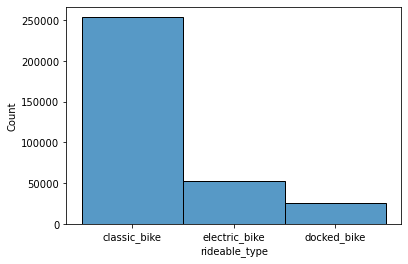

In [29]:
sns.histplot(data=df, x="rideable_type")

In [21]:
df["member_casual"].value_counts()

member    185200
casual    147621
Name: member_casual, dtype: int64

<AxesSubplot:xlabel='member_casual', ylabel='Count'>

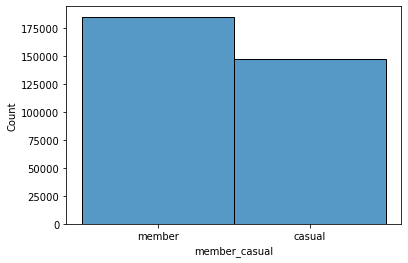

In [30]:
sns.histplot(data=df, x="member_casual")

<AxesSubplot:xlabel='rideable_type', ylabel='Count'>

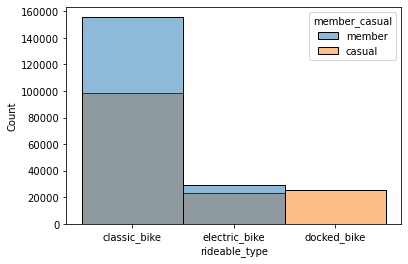

In [33]:
sns.histplot(data=df, x="rideable_type", hue="member_casual")

## Aggregating the data

We are going to drop what we don't need, create some new features, and then aggregate everything to the day.

In [61]:
day_df = (
    df.copy()
    .drop(columns=["start_lat", "start_lng", "end_lat", "end_lng"])
    .loc[lambda df: df["rideable_type"] != "docked_bike"]
    .assign(
        day = lambda df: df["started_at"].dt.day,
        month = lambda df: df["started_at"].dt.month,
        classic_bike = lambda df: df["rideable_type"].eq("classic_bike").map(int),
        electric_bike = lambda df: df["rideable_type"].eq("electric_bike").map(int),
        member = lambda df: df["member_casual"].eq("member").map(int),
        casual = lambda df: df["member_casual"].eq("casual").map(int)
        )
    .drop(columns=["ride_id", "rideable_type", "started_at", "ended_at", "start_station_name",
                   "start_station_id", "end_station_name", "end_station_id", "member_casual"])
    .groupby(["month", "day"]).sum()
    .assign(
        total_rides = lambda df: df["classic_bike"] + df["electric_bike"],
        year = 2022,
        month = lambda df: df.index.get_level_values(0),
        day = lambda df: df.index.get_level_values(1),
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]]),
    )
    .reset_index(drop=True)
    # .set_index("date")
    .drop(columns=["year", "month", "day"])
)


day_df

,classic_bike,electric_bike,member,casual,total_rides,date
0,6484,1253,4355,3382,7737,2022-05-01
1,8865,1561,6582,3844,10426,2022-05-02
2,9275,1833,7210,3898,11108,2022-05-03
3,8461,1852,6853,3460,10313,2022-05-04
4,8633,1872,6781,3724,10505,2022-05-05
5,3026,1047,2867,1206,4073,2022-05-06
6,2027,756,1958,825,2783,2022-05-07
7,5355,1374,4101,2628,6729,2022-05-08
8,7994,1762,6429,3327,9756,2022-05-09
9,9265,2052,7373,3944,11317,2022-05-10


<AxesSubplot:xlabel='date', ylabel='total_rides'>

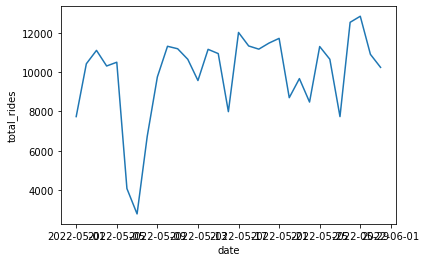

In [66]:
sns.lineplot(data=day_df, x="date", y="total_rides")